<a href="https://colab.research.google.com/github/anujsharma92/Multiple-Linear-Regression/blob/main/MLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np
import pandas as pd
from scipy import stats
import pylab
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm



In [92]:
startup=pd.read_csv("/content/50_Startups.csv")


In [93]:
startup.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [94]:
#converting categorical i/p to numerical
dummy_states=pd.get_dummies(startup['State'])
# renaming dummy
dummy_states.columns=["State"+str(i) for i in range(0, 3)]
dummy_states.head()


,State0,State1,State2
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0


In [95]:
#droping State from startup and cocatinating  dummy as well as
startup=startup.drop(['State'], axis=1)
frames=[dummy_states,startup]
final_startup=pd.concat(frames,axis=1)
final_startup.head()

,State0,State1,State2,R&D Spend,Administration,Marketing Spend,Profit
0,0,0,1,165349.20,136897.80,471784.10,192261.83
1,1,0,0,162597.70,151377.59,443898.53,191792.06
2,0,1,0,153441.51,101145.55,407934.54,191050.39
3,0,0,1,144372.41,118671.85,383199.62,182901.99
4,0,1,0,142107.34,91391.77,366168.42,166187.94


In [96]:
#checking correlation for feature selection
corr1=pd.DataFrame(final_startup.iloc[:,:-1].corr())
corr1

,State0,State1,State2,R&D Spend,Administration,Marketing Spend
State0,1.000000,-0.492366,-0.515152,-0.143165,-0.015478,-0.168875
State1,-0.492366,1.000000,-0.492366,0.105711,0.010493,0.205685
State2,-0.515152,-0.492366,1.000000,0.039068,0.005145,-0.033670
R&D Spend,-0.143165,0.105711,0.039068,1.000000,0.241955,0.724248
Administration,-0.015478,0.010493,0.005145,0.241955,1.000000,-0.032154
Marketing Spend,-0.168875,0.205685,-0.033670,0.724248,-0.032154,1.000000


In [97]:
#feature selection checking feature which exceeds threshold value
threshold=0.75
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

correlation(final_startup.iloc[:,:-1],threshold)
#none of feature exceeding our threshold value


set()

In [98]:
#renaming all features
final_startup.columns='state0','state1','state2','rd','admin','market','profit'
final_startup.head()

,state0,state1,state2,rd,admin,market,profit
0,0,0,1,165349.20,136897.80,471784.10,192261.83
1,1,0,0,162597.70,151377.59,443898.53,191792.06
2,0,1,0,153441.51,101145.55,407934.54,191050.39
3,0,0,1,144372.41,118671.85,383199.62,182901.99
4,0,1,0,142107.34,91391.77,366168.42,166187.94


In [99]:
#model 1

model1=smf.ols('profit~state0+state1+state2+rd+admin+market',data=final_startup).fit()
model1.summary()

#here R squared value is >0.80  strong model
#but  adminand market  p value is >0.05 but we cannot remove those fetures as its playing important role 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           1.34e-27
Time:                        07:22:42   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.763e+04   5073.636      7.417      0.000    2.74e+04    4.79e+04
state0      1.249e+04   2449.797      5.099      0.000    7554.868    1.74e+04
state1      1.269e+04   2726.700      4.654      0.000    7195.596    1.82e+04
state2      1.245e+04   2486.364      5.007      0.000    7439.285    1.75e+04
rd             0.8060      0.046     17.369      0.000       0.712       0.900
admin         -0.0270      0.052     -0.517      0.608      -0.132       0.078
market         0.0270      0.017      1.574      0.123      -0.008       0.062
==============================================================================
Omnibus:                       14.782   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.266
Skew:                          -0.948   Prob(JB):                     2.41e-05
Kurtosis:                       5.572   Cond. No.                     1.81e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

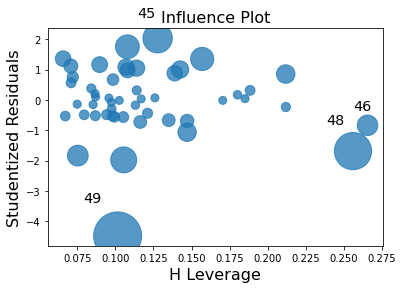

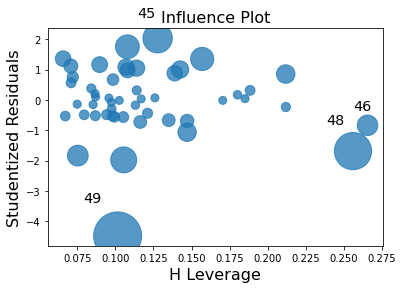

In [100]:
#check for influencial value
sm.graphics.influence_plot(model1)
#here 49 is looking most influenceable value 

In [101]:
#dropiing most influencer row
final_startup=final_startup.drop(final_startup.index[49])

In [102]:
#model 2
#transformation feature

model2=smf.ols('profit~state0+state1+state2+rd+np.log(admin)+market',data=final_startup).fit()
model2.summary()

#here R squared value is >0.80  strong model
#but  admin and market  p value is >0.05 but we cannot remove those fetures as its playing important role 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     215.5
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           2.78e-29
Time:                        07:22:59   Log-Likelihood:                -506.08
No. Observations:                  49   AIC:                             1024.
Df Residuals:                      43   BIC:                             1036.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.645e+04   3.99e+04      1.163      0.251   -3.41e+04    1.27e+05
state0         1.666e+04   1.34e+04      1.245      0.220   -1.03e+04    4.36e+04
state1         1.508e+04   1.35e+04      1.114      0.272   -1.22e+04    4.24e+04
state2         1.471e+04   1.33e+04      1.104      0.276   -1.22e+04    4.16e+04
rd                0.7794      0.039     19.995      0.000       0.701       0.858
np.log(admin) -1059.9018   4581.791     -0.231      0.818   -1.03e+04    8180.161
market            0.0272      0.014      1.921      0.061      -0.001       0.056
==============================================================================
Omnibus:                        0.083   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.959   Jarque-Bera (JB):                0.243
Skew:                           0.079   Prob(JB):                        0.886
Kurtosis:                       2.694   Cond. No.                     1.86e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.48e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

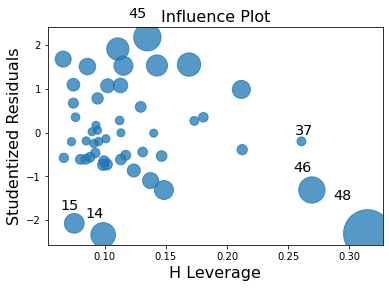

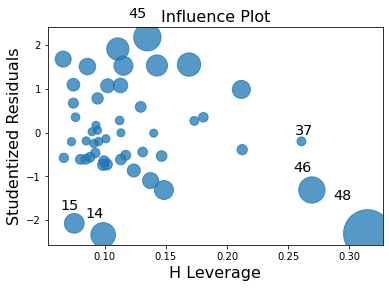

In [103]:
#check for influencial value
sm.graphics.influence_plot(model2)
#here 48 is looking most influenceable value 

In [104]:
#dropiing most influencer row
final_startup=final_startup.drop(final_startup.index[48])

In [105]:
#checking for VIF for checking any feature is invovling in multicollinearaity or not

rsq_st0 = smf.ols('state0~state1+state2+rd+admin+market',data=final_startup).fit().rsquared  
vif_st0 = 1/(1 - rsq_st0) 

rsq_st1 = smf.ols('state1~state0+state2+rd+admin+market',data=final_startup).fit().rsquared  
vif_st1 = 1/(1 - rsq_st1)

rsq_st2 = smf.ols('state2~state0+state1+rd+admin+market',data=final_startup).fit().rsquared  
vif_st2 = 1/(1 - rsq_st2) 

rsq_rd = smf.ols('rd~state0+state1+state2+admin+market',data=final_startup).fit().rsquared  
vif_rd = 1/(1 - rsq_rd) 

rsq_admin = smf.ols('admin~state0+state1+state2+rd+market',data=final_startup).fit().rsquared  
vif_admin = 1/(1 - rsq_admin)

rsq_market = smf.ols('market~state0+state1+state2+rd+admin',data=final_startup).fit().rsquared  
vif_market = 1/(1 - rsq_market) 


d1 = {'Variables':['State0','State1','State02','rd', 'admin', 'market'], 'VIF':[vif_st0,vif_st1,vif_st2,vif_rd, vif_admin, vif_market]}
Vif_frame = pd.DataFrame(d1)  
Vif_frame
# we are getting vif inf for all state column so removing all state feature will help us to  build good model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


,Variables,VIF
0,State0,inf
1,State1,inf
2,State02,inf
3,rd,2.268965
4,admin,1.202930
5,market,2.305283


In [106]:
#removing State columns as vif is inf
final_startup=final_startup.drop(['state0','state1','state2'],axis=1)

#splitting data in train and test 

from sklearn.model_selection import train_test_split

train,test= train_test_split(final_startup, test_size = 0.10,random_state=10)

new_model=smf.ols('profit~rd+admin+market',data=train).fit()
new_model.summary()

test_pred = new_model.predict(test)
test_pred

test_resid = test_pred - test.profit
# RMSE value for test data 
test_rmse = np.sqrt(np.mean(test_resid * test_resid))
test_rmse

#here test rmse i6806.96    which is very large  , hence we need more data for geeting better results

6806.960468960473